In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

### Создание датасета:
### Случайный лес не требует тестовых данных. Однако для независимой оценки создадим вилидационные данные:

In [2]:
X, Y = make_classification(n_samples=1000, n_features=5, n_informative=4, n_redundant=1, n_classes=4, random_state=7)

# Добавление в датасет пустых значений - написанный скрипт работает с пустыми значениями
X[300, 0] = None
X[2, 0] = None
X[100, 0] = None
X[700, 1] = None
X[500, 1] = None

# Разбиение на тренировочную и валидационные выборки
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=13)

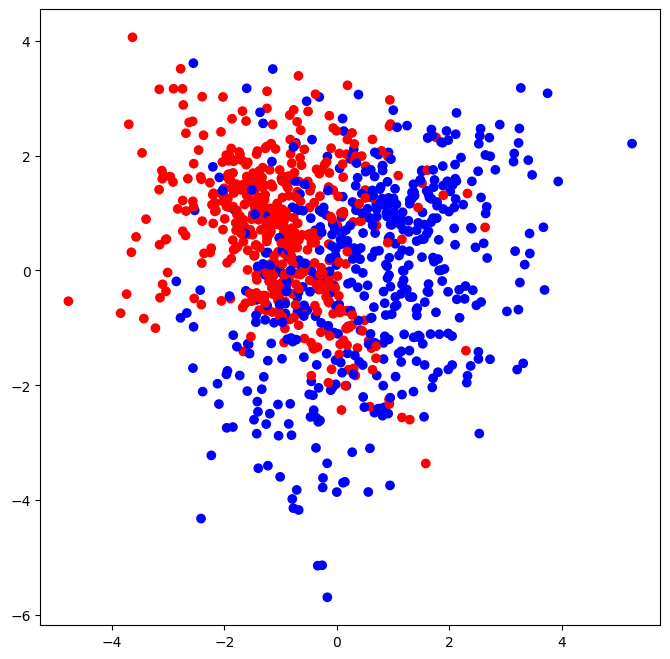

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=Y, cmap=colors)
plt.show()

### Функция приращения информации основывается на расчете энтропийного критерия Шеннона (критерий информативности классификатора дерева решений):
$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$. $p_{k}$ будет характеризовать вероятность выдачи класса $k$.

### Класс дерева:

In [4]:
class Tree:
    
    def __init__(self, x_train, y_train, x_test, y_test, min_count_of_samples_per_branch=5):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.min_count_of_samples_per_branch = min_count_of_samples_per_branch
    
    
    
    # Расчет доли объектов, равных k в выборке Y (пример: какова доля "1" по отношению ко всей выборке)
    # т.е. расчет доли объектов в выборке для каждого класса
    @staticmethod
    def _count_object_for_k_class(Y, k):
        p = 1/Y.shape[0] * Y[Y==k].shape[0]
        return p
    
    
    
    # Расчет критерия Шеннона (энтропии)
    @staticmethod
    def _full_entropia(Y):
        H = 0
        for k in np.unique(Y):
            p = Tree._count_object_for_k_class(Y, k)
            H += p * np.log2(p)

        return -H
    
    
    
    # Расчет коэффициента качества
    @staticmethod
    def _quality_koef(y_left_branch, y_right_branch, current_shennon_criteria):

        # Доля выборки, ушедшей в левую ветку
        p = y_left_branch.shape[0] / (y_left_branch.shape[0] + y_right_branch.shape[0])

        # Коэффициент качества
        return current_shennon_criteria - p * Tree._full_entropia(y_left_branch) - (1-p) * Tree._full_entropia(y_right_branch)
    
    
    
    # Функция разделяет выборку на две ветки: левую и правую.
    # Критерий - сравнение наблюдения в массиве x по индексу index с номинальным t
    # Функция обрабатывает Null - значения из массива x
    @staticmethod
    def _split_branch(x, y, index, t):

        x_left_branch = []
        y_left_branch = []
        x_right_branch = []
        y_right_branch = []

        for i in range(x.shape[0]):

            # Обработка Null - значений:
            if x[i, index] == None:
                x_left_branch.append(x[i, :])
                y_left_branch.append(y[i])
                x_right_branch.append(x[i, :])
                y_right_branch.append(y[i])

            elif x[i, index] <= t:
                x_left_branch.append(x[i, :])
                y_left_branch.append(y[i])

            else:
                x_right_branch.append(x[i, :])
                y_right_branch.append(y[i])

        return np.array(x_left_branch), np.array(y_left_branch), np.array(x_right_branch), np.array(y_right_branch)
    
    
    
    # Макрос поиска наилучшего критерия для разбиения на левую и правую ветки
    @staticmethod
    def _find_best_split(x, y, min_count_of_samples_per_branch):
    # Критерий выбора наилучшего значения: максимальное значение параметра качества - best_quality (прирост информации)
        best_t = None    # Значение параметра t, при котором достигается наилучшее качество (прирост информации)
        best_index = None    # Значение индекса столбца  массива x, при котором достигается наилучшее качество (прирост информации)  
        best_quality = 0    # Переменная, хранящая значения качества (прирост информации)
        current_entropia = Tree._full_entropia(y)    # Переменная, хранящая текущую энтропию для данной выборки

        # Макрос выполняет поиск не по всем признакам выборки, а только по некоторым, выбранным случайно:
        indexes = Tree._get_random_indexes(x)
        
        for index in indexes:
            for row in range(x.shape[0]):
                t = x[row,index]
                x_left_branch, y_left_branch, x_right_branch, y_right_branch = Tree._split_branch(x, y, index, t)

                # Проверка, достаточно ли образцов и листе - борьба с переобучением
                if y_left_branch.shape[0] < min_count_of_samples_per_branch or y_right_branch.shape[0] < min_count_of_samples_per_branch:
                    continue

                # Расчет прироста информации на данной итерации
                current_quality = Tree._quality_koef(y_left_branch, y_right_branch, current_entropia)

                if current_quality > best_quality:
                    best_quality = current_quality
                    best_index = index
                    best_t = x[row,index]

        return best_index, best_t, best_quality       
    
    
    
    # Макрос рекурсивного создания узлов и листьев дерева
    @staticmethod
    def _build_node(x, y, min_count_of_samples_per_branch):
        best_index, best_t, best_quality = Tree._find_best_split(x, y, min_count_of_samples_per_branch=min_count_of_samples_per_branch)

        #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества или когда образцов в листе меньше заданного
        if best_quality == 0 or y.shape[0] < min_count_of_samples_per_branch:
            return Leaf(x, y)

        x_left_branch, y_left_branch, x_right_branch, y_right_branch = Tree._split_branch(x, y, best_index, best_t)

        # Рекурсивное добавление левой и правой веток
        left_branch = Tree._build_node(x_left_branch, y_left_branch, min_count_of_samples_per_branch=min_count_of_samples_per_branch)
        right_branch = Tree._build_node(x_right_branch, y_right_branch, min_count_of_samples_per_branch=min_count_of_samples_per_branch)

        return Node(best_index, best_t, left_branch, right_branch)
    
    
    
    # Макрос создания дерева
    def build_tree(self):
        self.tree = Tree._build_node(self.x_train, self.y_train, self.min_count_of_samples_per_branch)
        print(f'На тренировочной выборке OOB составляет: {round(Tree._get_out_of_begging_error(self.y_train, self.predict(self.x_train)), 3)}')
        print(f'На тестовой выборке OOB составляет: {round(Tree._get_out_of_begging_error(self.y_test, self.predict(self.x_test)), 3)}')
        print()
    
    
    
    # Функция предсказывания для одного наблюдения из массива X
    @staticmethod
    def _classify_object(x, tree_subclass):
        #  Останавливаем рекурсию, если достигли класса листа - именно листья возвращают нам наш целевой класс
        if isinstance(tree_subclass, Leaf):
            answer = tree_subclass.predict()
            return answer

        #  Сравнение значений в массиве x с целевыми параметрами t
        if x[tree_subclass.index] <= tree_subclass.t:
            return Tree._classify_object(x, tree_subclass.left_branch)
        else:
            return Tree._classify_object(x, tree_subclass.right_branch)
    
    
    
    # Функция предсказывания
    def predict(self, x):
        # Функция предсказывания значений для всех наблюдений в массиве X
        classes = []
        for sample in x:
            prediction = self._classify_object(sample, self.tree)
            classes.append(prediction)
        return classes
    
    
    # Функция расчета out of beggin error
    @staticmethod
    def _get_out_of_begging_error(y_true, y_pred):
        k = 0
        for i in range(y_true.shape[0]):
            if y_true[i] == y_pred[i]:
                k += 1
        return k / y_true.shape[0]
    
    
    
    # Функция выбора случайного набора индексов для метода подмножеств
    @staticmethod
    def _get_random_indexes(x):
    
        total_indexes = [el for el in range(x.shape[1])]
        
        result_indexes = []
        
        for i in range(int(np.sqrt(x.shape[1]))):
            result_indexes.append(total_indexes.pop(random.randint(0, len(total_indexes)-1)))
        
        return result_indexes

### Класс узла дерева:

In [5]:
# Класс узла дерева
class Node:
    
    def __init__(self, index, t, left_branch, right_branch):
        self.index = index        # index - индекс столбца массива признаков X, по которому производится сравнение
        self.t = t        # t - значение граничного параметра для столбца с данным индексом, по которому разделяется выборка на левую и правую части
        self.left_branch = left_branch        # left_branch - левая ветка дерева
        self.right_branch = right_branch        # right_branch - правая ветка дерева

### Класс листа дерева:

In [6]:
class Leaf:
                                    # Конструктор класса. На вход принимает массив X (признаки) и массив Y (целевые классы)
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.predicted_class = self.predict()
        
                                    # Функция - предсказывание. Предсказывает целевой класс для данного листа
                                    # Класс, объектов которого будет большинство в данном листе, будет возвращен
    def predict(self):
        count_unique_values = []
        unique_values = np.unique(self.y)
        for k in unique_values:
            count_unique_values.append(self.y[self.y==k].shape[0])
        
        maximum_count = 0
        target_class = 0
        for i, value in enumerate(count_unique_values):
            if maximum_count < value:
                target_class = unique_values[i]
                
        return target_class

### Класс случайного леса (классификатор):

In [7]:
class Random_Forest_Classifier:
    
    def __init__(self, x, y, trees_count, test_size = 0.37, min_count_of_samples_per_branch=1):
        self.x = x
        self.y = y
        self.trees_count = trees_count
        self.test_size = test_size
        self.min_count_of_samples_per_branch = min_count_of_samples_per_branch
     
    
    
    # Функция производит разбиение индексов наборов данных на тестовую и тренировочную выборки
    def get_train_test_indexes(self):
        n_rows_train = int(self.x.shape[0] * (1-self.test_size))     # Количество наблюдений для обучения каждого дерева
        n_rows_test = self.x.shape[0] - n_rows_train                 # Количество наблюдений для тестирования каждого дерева
        
        test_indexes = []
        train_indexes = [el for el in range(self.x.shape[0])]
        
        for i in range(n_rows_test):
            test_indexes.append(train_indexes.pop(random.randint(0, len(train_indexes) - 1)))
            
        for i in range(self.y.shape[0] - n_rows_train):
            train_indexes.append(random.choice(train_indexes))
            
        return train_indexes, test_indexes
    
    
    
    # Функция создает для каждого дерева тренировочную и тестовую выборку методом бутстрапа
    # Сколько деревье - столько и выборок 
    def make_bootstrap(self):
        
        n_trees = self.trees_count
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        
        for i in range(n_trees):
            current_x_train = []
            current_x_test = []
            current_y_train = []
            current_y_test = []
            
            train_indexes, test_indexes = self.get_train_test_indexes()
        
            
            for j in range(len(train_indexes)):
                current_x_train.append(self.x[train_indexes[j], :])
                current_y_train.append(self.y[train_indexes[j]])
                
            for j in range(len(test_indexes)):
                current_x_test.append(self.x[test_indexes[j], :])
                current_y_test.append(self.y[test_indexes[j]])
            
            x_train.append(np.array(current_x_train))
            x_test.append(np.array(current_x_test))
            y_train.append(np.array(current_y_train))
            y_test.append(np.array(current_y_test))
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    
    # Функция создает деревья решений для каждой тестовой и тренировочной выборки
    def make_desicion_trees(self):
        trees = []
        for i in range(self.trees_count):
            tree = Tree(self.x_train[i], self.y_train[i], self.x_test[i], self.y_test[i], self.min_count_of_samples_per_branch)
            tree.build_tree()
            trees.append(tree)
        self.trees = trees
        
    
    # Функция вычисления предсказаний для каждого дерева внутри случайного леса
    def _predict(self, x):
        predicted_values = []
        for tree in self.trees:
            predicted_values.append(tree.predict(x))
        self.predicted_values = np.array(predicted_values)
        
    # Функция вычисления финального предсказания случайного леса (на основе "голосования" деревьев)
    def make_final_prediction(self, x):
        self._predict(x)
        predictions_list = []
        
        for i in range(self.predicted_values.shape[1]):
            predictions_list.append([])
            for j in range(self.predicted_values.shape[0]):
                predictions_list[i].append(self.predicted_values[j,i])
        
        predicted_classes = []
        for el in predictions_list:
            counts = np.bincount(el)
            predicted_classes.append(np.argmax(counts))
        
        return np.array(predicted_classes)

### Запуск и работа скрипта представлены ниже:

In [8]:
rfc = Random_Forest_Classifier(x_train, y_train, 1, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.66

На обучающей выборке OOB = 0.874
На валидационной выборке OOB = 0.697
Количество деревье: 1


In [9]:
rfc = Random_Forest_Classifier(x_train, y_train, 3, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.714

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.587

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.614

На обучающей выборке OOB = 0.934
На валидационной выборке OOB = 0.71
Количество деревье: 3


In [10]:
rfc = Random_Forest_Classifier(x_train, y_train, 10, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.68

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.718

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.691

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.687

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.637

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.66

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.645

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.664

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.649

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.61

На обучающей выборке OOB = 0.99
На валидационной выборке OOB = 0.773
Количество деревье: 10


In [11]:
rfc = Random_Forest_Classifier(x_train, y_train, 50, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке accuracy = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке accuracy = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.664

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.641

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.653

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.645

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.637

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.568

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.622

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.676

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.591

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.579

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.625

На тренировочной выборке OOB сос